In [1]:
import sys
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [2]:
def ldaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix 
    
    # IMPLEMENT THIS METHOD
    
    numberOfClasses = (np.unique(y)).shape[0]
    meansList = []
    
    for index in range (numberOfClasses):
        class_members = np.where(index+1==y)
        class_members = class_members[0]
        
        trainingExample = X[class_members,:]
        
        classMean = np.mean(trainingExample, axis=0)
        meansList.append(classMean)
        
    means = np.asarray(meansList)
    means = means.T

    covmat = np.cov(X.T)
    
    return means,covmat

In [3]:
def qdaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes
    
    # IMPLEMENT THIS METHOD
    
    covmats = []
    meansList = []
    
    numberOfClasses = (np.unique(y)).shape[0]
    
    for index in range (numberOfClasses):
        
        classMembers = np.where(index+1==y)
        classMembers = classMembers[0]
        trainingData = X[classMembers,:]
        
        row_mean = np.mean(trainingData, axis=0)
        meansList.append(row_mean)
        oneCovMat = np.cov(trainingData.T)
        covmats.append(oneCovMat)
    means = np.asarray(meansList)
    means = means.T
    
    return means,covmats

In [4]:
def ldaTest(means,covmat,Xtest,ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels
    
    ll = []
    N = ytest.shape[0]
    d = Xtest.shape[1]
    number_of_classes = means.shape[1]

    covmatdeterminant = np.linalg.det(covmat)
    covmatinverse = np.linalg.inv(covmat)
    
    for index in range(number_of_classes):
        
        XMeans = (Xtest - means[:,index])       #Nxd
        trans_covinv = np.dot(XMeans,covmatinverse)   # Nxd
        trans_covinv_xm_p = trans_covinv * XMeans   #Nxd
        trans_covinv_xm_s = np.sum(trans_covinv_xm_p, axis=1)  #Nx1
        trans_covinv_xm = -0.5 * trans_covinv_xm_s 
        numerator = np.exp(trans_covinv_xm)
        denominator = np.power((np.pi*2),d/2)*np.sqrt(covmatdeterminant)
        
        likelihood =  numerator / denominator 
        ll.append(likelihood)
        
    ll_mat = np.asarray(ll)
    ll_mat = ll_mat.T
    
    ypred = np.argmax(ll_mat, axis=1)+1
    result = np.zeros(N)
    for i in range(N):
        if(ypred[i] == ytest[i]):
            result[i] = 1
    
    acc = np.mean(result)*100
    
    return acc,ypred

In [5]:
def qdaTest(means,covmats,Xtest,ytest):
    # Inputs
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    N = ytest.shape[0]
    d = Xtest.shape[1]
    
    numberOfClasses = means.shape[1]
    ll = []
    
    for index in range(numberOfClasses):
        
        XMeans = (Xtest - means[:,index])   #Nxd

        covmatdeterminant = np.linalg.det(covmats[index])
        covmatinverse = np.linalg.inv(covmats[index])
                
        trans_covinv = np.dot(XMeans,covmatinverse)  #Nxd
        trans_covinv_xm_p = trans_covinv * XMeans     #Nxd
        trans_covinv_xm_s = np.sum(trans_covinv_xm_p, axis=1)    #Nxd
        trans_covinv_xm = -0.5 * trans_covinv_xm_s     #Nx1
        numerator = np.exp(trans_covinv_xm)
        denominator = np.power((np.pi*2),d/2)*np.sqrt(covmatdeterminant)
        likelihood = numerator / denominator
        ll.append(likelihood)
    
    ll_mat = np.asarray(ll)
    ll_mat = ll_mat.T

    ypred = np.argmax(ll_mat, axis=1)+1
    result = np.zeros(N)
    for i in range(N):
        if(ypred[i] == ytest[i]):
            result[i] = 1
            
    acc = np.mean(result)*100
    
    
    return acc,ypred

In [6]:
#Problem 2
def learnOLERegression(X,y):
    # Inputs:
    # X = N x d
    # y = N x 1
    # Output:
    # w = d x 1

    transpose_X = np.transpose(X)
    a = np.dot(transpose_X,X)
    b = np.dot(transpose_X,y)
    inverse = np.linalg.inv(a)

    w = np.dot(inverse,b)
    print(w.shape)

    return w

In [7]:
def testOLERegression(w,Xtest,ytest):
    # Inputs:
    # w = d x 1
    # Xtest = N x d
    # ytest = X x 1
    # Output:
    # rmse
    
    one_over_N = 1.0/Xtest.shape[0] #1/N
    transpose_w = np.transpose(w)
    transpose_X = np.transpose(Xtest)
    transpose_y = np.transpose(ytest)

    a = np.dot(transpose_w,transpose_X)
    b = np.subtract(transpose_y, a)
    c = np.power(b,2)
    d = np.dot(c, one_over_N)
    sum_vector = np.sum(d)
    rmse = np.sqrt(sum_vector)
   
    
    return rmse

In [8]:
def learnRidgeRegression(X,y,lambd):
    # Inputs:
    # X = N x d                                                               
    # y = N x 1 
    # lambd = ridge parameter (scalar)
    # Output:                                                                  
    # w = d x 1   
    
    # IMPLEMENT THIS METHOD
    
    # added : by Zulkar
    d = X.shape[1]
    X_transpose = np.transpose(X)
    X_squared = np.dot(X_transpose,X)
    lambda_Id = lambd * np.identity(d)
    
    part_1 = lambda_Id + X_squared
    inv_part_1 = np.linalg.inv(part_1)
    part_2 = np.dot(inv_part_1,X_transpose)
    w = np.dot(part_2,y)
    
    
    
    
                                                       
    return w

In [9]:
def regressionObjVal(w, X, y, lambd):
    
    # error J(w) = 0.5 * sum(y - wt.x)^2 + 0.5*lambda*(wt.w)
    w_new = w.reshape((w.shape[0],1))
    wt_x = np.dot(X,w_new)
    y_minus_wtx = y - wt_x;
    squared_error = np.sum(np.square( y_minus_wtx ))
    error = 0.5 * squared_error + (0.5 * lambd * np.dot(w.T,w))
    
    
    #error_grad = d/dw {J(w)} : (Xt.X).w - Xt.y + lambda * w  : dimension : 65x1 
    XtX = np.dot(X.T,X)
    XtX_w = np.dot(XtX,w_new)
    Xty = np.dot(X.T,y)
    lambda_w = lambd * w_new
    
    error_grad = (XtX_w - Xty + lambda_w)
    error_grad = error_grad.flatten()
    
    return error, error_grad

In [10]:
#Problem 5
def mapNonLinear(x,p):
    # Inputs:
    # x - a single column vector (N x 1)
    # p - integer (>= 0)
    # Outputs:
    # Xd - (N x (p+1))
    
    
    N = x.shape[0]
    Xd = np.zeros((N,p+1))
    '''
    for i in (0, N-1):
        for k in (0,p):
            Xd[i][k] = x[k] ** k
            # print(Xd[i][k])
    '''
    
    for index in range(0, p+1):
        Xd[:, index] = x ** index   
    # print(Xd.shape)
    
    return Xd

LDA Accuracy = (97.0, array([2, 2, 3, 4, 3, 2, 5, 4, 4, 4, 3, 5, 2, 2, 4, 1, 1, 1, 5, 3, 5, 1, 4,
       3, 5, 1, 1, 2, 5, 2, 5, 5, 3, 5, 3, 4, 2, 3, 1, 2, 4, 5, 1, 1, 4, 4,
       5, 3, 5, 5, 5, 4, 1, 5, 4, 4, 1, 3, 3, 1, 1, 4, 5, 3, 5, 4, 2, 3, 3,
       3, 5, 2, 2, 1, 4, 4, 4, 1, 1, 4, 1, 3, 4, 5, 3, 4, 3, 3, 3, 2, 5, 1,
       5, 2, 5, 4, 4, 5, 5, 1]))
QDA Accuracy = (96.0, array([2, 2, 3, 4, 3, 2, 5, 4, 4, 4, 3, 5, 2, 2, 4, 1, 1, 1, 5, 3, 5, 1, 4,
       3, 5, 1, 1, 2, 5, 2, 5, 5, 3, 5, 3, 4, 2, 3, 1, 2, 4, 5, 2, 1, 4, 4,
       5, 3, 5, 5, 5, 4, 1, 5, 4, 4, 1, 3, 3, 1, 1, 4, 5, 3, 5, 4, 2, 3, 3,
       3, 5, 2, 2, 1, 4, 4, 4, 1, 1, 4, 1, 3, 4, 5, 3, 4, 3, 3, 3, 2, 5, 1,
       5, 2, 5, 4, 4, 5, 5, 1]))


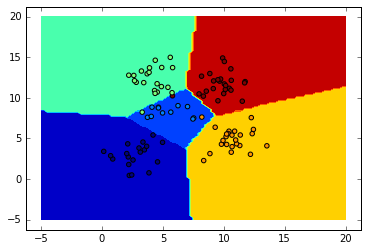

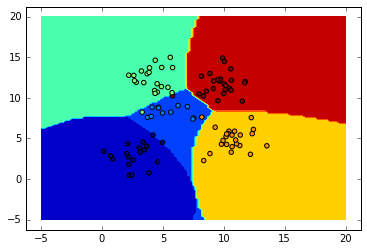

(64, 1)
(65, 1)
RMSE without intercept 326.764994391
RMSE with intercept 60.8920370941


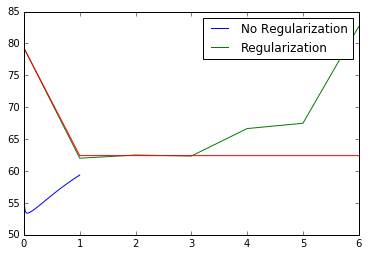

In [13]:
# Main script

# Problem 1
# load the sample data                                                                 
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')

# LDA
means,covmat = ldaLearn(X,y)
ldaacc = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))
# QDA
means,covmats = qdaLearn(X,y)
qdaacc = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))

# plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])))
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest)

plt.show()

zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])))
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest)

plt.show()

# Problem 2

if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'),encoding = 'latin1')

# add intercept
X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)

w = learnOLERegression(X,y)
mle = testOLERegression(w,Xtest,ytest)

w_i = learnOLERegression(X_i,y)
mle_i = testOLERegression(w_i,Xtest_i,ytest)

print('RMSE without intercept '+str(mle))
print('RMSE with intercept '+str(mle_i))

# Problem 3
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
rmses3 = np.zeros((k,1))
for lambd in lambdas:
    w_l = learnRidgeRegression(X_i,y,lambd)
    rmses3[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
plt.plot(lambdas,rmses3)

# Problem 4
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
rmses4 = np.zeros((k,1))
opts = {'maxiter' : 100}    # Preferred value.                                                
w_init = np.ones((X_i.shape[1],1))
for lambd in lambdas:
    args = (X_i, y, lambd)
    # w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='BFGS', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    rmses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
plt.plot(lambdas,rmses4)


# Problem 5
pmax = 7
lambda_opt = lambdas[np.argmin(rmses4)]
rmses5 = np.zeros((pmax,2))
for p in range(pmax):
    Xd = mapNonLinear(X[:,2],p)
    Xdtest = mapNonLinear(Xtest[:,2],p)
    w_d1 = learnRidgeRegression(Xd,y,0)
    rmses5[p,0] = testOLERegression(w_d1,Xdtest,ytest)
    w_d2 = learnRidgeRegression(Xd,y,lambda_opt)
    rmses5[p,1] = testOLERegression(w_d2,Xdtest,ytest)
plt.plot(range(pmax),rmses5)
plt.legend(('No Regularization','Regularization'))
